# 01 - Exploratory Data Analysis

## 1. Import Packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
import math
import pprint as pp

from sklearn.preprocessing import StandardScaler

In [3]:
#make folder for storing images
if 'img' not in os.listdir():
    os.mkdir('img')

## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Import Data](#import_data)
3. [Cleaning Data](#clean)
    1. [Dropping Columns and Null-Values](#drop)
    2. [Checking for NaN in Float64 Columns](#float)
    3. [Modifying Features](#modify)
    4. [Defining the Target Variable](#target)
    5. [DateTime Objects](#date)
    6. [One-Hot Encoding Categories](#encode)
    7. [Type-Casting Columns](#type-cast)
4. [Plotting Data](#plots)
5. [Data Leakage](#leak)
6. [Saving Data](#save)

## 2. Import Data <a name="import_data"></a>

The data for the project was obtained from https://www.kaggle.com/kemical/kickstarter-projects/data# <br>
The files were compressed using `gzip` in terminal.

In [6]:
if 'data' not in os.listdir():
    os.mkdir('data')
    
file_dir = os.path.abspath('.')
csv_folder = 'data'

In [3]:
path = os.path.join(file_dir, csv_folder, 'ks-projects-201612.csv.gz')
#this specific file requires a special type of encoding
ks2016 = pd.read_csv(path, encoding = 'cp1252', low_memory = False)

#cleaning the column names 
ks2016.columns = [col.strip().lower() for col in ks2016.columns]
    
ks2016.head()

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,unnamed: 13,unnamed: 14,unnamed: 15,unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [7]:
path = os.path.join(file_dir, csv_folder, 'ks-projects-201801.csv.gz')
ks2018 = pd.read_csv(path, low_memory = False)

#cleaning the column names 
ks2018.columns = [col.strip().lower() for col in ks2018.columns]
    
ks2018.head()

,id,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


It seems that the data from ks-projects-201801.csv has all we need. <br>
The .csv file all the data from the ks-projects-201612.csv, plus 54911 unique entries. <br>
For the remainder of the project, we will only be using this dataset.

In [5]:
ks2016_id, ks2018_id = set(ks2016['id']), set(ks2018['id'])
print('Number of Unique IDs in ks2016: ' + str(len(ks2016_id)))
print('Number of Unique IDs in ks2018: ' + str(len(ks2018_id)))
print('Difference in Number of IDs: ' + str(len(ks2018_id) - len(ks2016_id)))
print('ks2018 Has This Many More Unique IDs: ' + str(len(ks2018_id.difference(ks2016_id))))

Number of Unique IDs in ks2016: 323750
Number of Unique IDs in ks2018: 378661
Difference in Number of IDs: 54911
ks2018 Has This Many More Unique IDs: 54911


Return to [Table of Contents](#table)

## 3. Cleaning Data <a name="clean"></a>

We are specifically cleaning the data in 'ks2018'.

### 3A. Dropping Columns and Null-Values <a name="drop"></a>

Columns like 'id' or 'category' were dropped since they were too specific. <br>
Columns like 'pledged' and 'goal' were removed since their amounts where in non-U.S. dollar amounts. <br>
Their actual U.S. dollar amounts are already captured in 'usd_pledged_real' and 'usd_goal_real'. <br>
The column 'usd pledged' was removed since it had missing values and was redundant - given 'usd_pledged_real'. <br>
The information in column 'category' is also captured in 'country'.

In [6]:
ks2018 = ks2018.drop(columns = ['id', 'currency', 'category', 'usd pledged', 'pledged', 'goal'])
ks2018.head()

,name,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,The Songs of Adelaide & Abullah,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,Where is Hank?,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


In [7]:
ks2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 9 columns):
name                378657 non-null object
main_category       378661 non-null object
deadline            378661 non-null object
launched            378661 non-null object
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 26.0+ MB


There are enough observations in the dataframe that we can afford to drop observations with null values.

In [8]:
ks2018 = ks2018[~ks2018['name'].isna()]
ks2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 9 columns):
name                378657 non-null object
main_category       378657 non-null object
deadline            378657 non-null object
launched            378657 non-null object
state               378657 non-null object
backers             378657 non-null int64
country             378657 non-null object
usd_pledged_real    378657 non-null float64
usd_goal_real       378657 non-null float64
dtypes: float64(2), int64(1), object(6)
memory usage: 28.9+ MB


Return to [Table of Contents](#table)

### 3B. Checking for NaN in Float64 Columns <a name="float"></a>

Technically, a np.nan is also considered a non-null float64 object in pandas. <br>
It is best to check we are truly dealing with non-null values before proceeding further. <br>
As it turns out, all the float64 values in our dataframe 'ks2018' are non-null. 

In [9]:
na_indices = []
float64_cols = ['usd_pledged_real', 'usd_goal_real']

def check_na(row):
    """
        Helper function to find NaN objects
        The dataframe indices of NaN objects are stored to na_indices
        
        :param row: a pandas DataFrame row
    """
    index = row.index
    
    for col in float64_cols:
        entry = row[col]
        if pd.isna(entry):
            na_indices.append(index)

ks2018.apply(check_na, axis=1)
            
print('Number of NaN Objects: ' + str(len(na_indices)))

ks2018 = ks2018[~ks2018.index.isin(na_indices)]

Number of NaN Objects: 0


Return to [Table of Contents](#table)

### 3C. Modifying Features <a name="modify"></a>

A new feature named 'title_length' was created from 'name' since 'name' is too specific. <br>
The assumption is that title length affects whether a Kickstarter backer will click on a project or not.

In [10]:
ks2018['name'] = ks2018['name'].apply(lambda title: len(title.split(' ')))

ks2018 = ks2018.rename(columns = {'name':'title_length',
                                  'usd_pledged_real':'pledged',
                                  'usd_goal_real':'goal'})

ks2018.head()

,title_length,main_category,deadline,launched,state,backers,country,pledged,goal
0,6,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,8,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,3,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,7,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,8,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


A one-hot encoding of the feature 'country' named 'US' was created from 'country'. <br>
It is possible that non-U.S. Kickstarter projects draw less support. 

In [11]:
ks2018.loc[ks2018['country'] != 'US', 'country'] = 0
ks2018.loc[ks2018['country'] == 'US', 'country'] = 1

ks2018['country'] = ks2018['country'].astype(np.uint8)
ks2018 = ks2018.rename(columns = {'country':'US'})
ks2018.head()

,title_length,main_category,deadline,launched,state,backers,US,pledged,goal
0,6,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,0,0.0,1533.95
1,8,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,1,2421.0,30000.00
2,3,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,1,220.0,45000.00
3,7,Music,2012-04-16,2012-03-17 03:24:11,failed,1,1,1.0,5000.00
4,8,Film & Video,2015-08-29,2015-07-04 08:35:03,canceled,14,1,1283.0,19500.00


Return to [Table of Contents](#table)

### 3D. Defining the Target Variable <a name="target"></a>

The target variable was created from a one-hot encoding of the column 'state'. <br>
We are only interested in Kickstarter campaigns that have either failed or succeeded.

In [12]:
ks2018['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [13]:
#only include campaigns with a 'failed' or 'successful' state
states = ['failed', 'successful']
ks2018 = ks2018[ks2018['state'].isin(states)]

success_mask = ks2018['state'] == 'successful'

#assign 0 to 'failed' and 1 to 'successful'
ks2018.loc[~success_mask, 'state'] = 0
ks2018.loc[success_mask, 'state'] = 1

ks2018 = ks2018.rename(columns = {'state':'successful'})

ks2018.head()

,title_length,main_category,deadline,launched,successful,backers,US,pledged,goal
0,6,Publishing,2015-10-09,2015-08-11 12:12:28,0,0,0,0.0,1533.95
1,8,Film & Video,2017-11-01,2017-09-02 04:43:57,0,15,1,2421.0,30000.00
2,3,Film & Video,2013-02-26,2013-01-12 00:20:50,0,3,1,220.0,45000.00
3,7,Music,2012-04-16,2012-03-17 03:24:11,0,1,1,1.0,5000.00
5,3,Food,2016-04-01,2016-02-26 13:38:27,1,224,1,52375.0,50000.00


In [14]:
#sanity check for success
num_successes = ks2018[ks2018['successful'] == 1].shape[0]
print('Number of Successes (Before Check): ' + str(num_successes))

ks2018.loc[ks2018['pledged'] >= ks2018['goal'], 'successful'] = 1
ks2018.loc[ks2018['pledged'] < ks2018['goal'], 'successful'] = 0

num_successes = ks2018[ks2018['successful'] == 1].shape[0]
print('\nNumber of Successes (After Check): ' + str(num_successes))

Number of Successes (Before Check): 133956

Number of Successes (After Check): 133957


Return to [Table of Contents](#table)

### 3E. DateTime Objects <a name="date"></a>

The project duration was then extracted from the columns 'deadline' and 'launched'. <br>
The entries in 'deadline' and 'launched' were converted to pandas DateTime objects. <br>
The two columns were then subtracted to give 'project_duration'. <br>
The entries in 'project_duration' were converted from pandas DateTime objects to fractions of days.

In [15]:
ks2018['year'] = ks2018['launched'].apply(lambda date: date[:4])

#convert the entries in the columns 'deadline' and 'launched' to datetime
ks2018['deadline'] = pd.to_datetime(ks2018['deadline'])
ks2018['launched'] = pd.to_datetime(ks2018['launched'])

#subtract 'deadline' and 'launched' to get 'project_duration'
ks2018['project_duration'] = ks2018['deadline'] - ks2018['launched']
ks2018 = ks2018.drop(columns = ['launched', 'deadline'])


def duration_to_day_fraction(duration):
    """
        Helper function to convert pandas DateTime 
        into fractions of days
        
        :param duration: a pandas DateTime object
    """
    days, seconds = duration.days, duration.seconds
    day_fraction = seconds / (3600 * 24)
    return round(days + day_fraction, 2)


ks2018['project_duration'] = ks2018['project_duration'].apply(duration_to_day_fraction)
ks2018.head()

,title_length,main_category,successful,backers,US,pledged,goal,year,project_duration
0,6,Publishing,0,0,0,0.0,1533.95,2015,58.49
1,8,Film & Video,0,15,1,2421.0,30000.00,2017,59.80
2,3,Film & Video,0,3,1,220.0,45000.00,2013,44.99
3,7,Music,0,1,1,1.0,5000.00,2012,29.86
5,3,Food,1,224,1,52375.0,50000.00,2016,34.43


According to Kickstarter, campaigns tend to succeed if they run for 30 days or less. <br>
We will attempt to verify that with a new categorical feature, 'min_30_days'. <br>
If the project duration is 30 days or less, it is 1. Otherwise, 0.

In [16]:
ks2018['min_30_days'] = ks2018['project_duration'].apply(lambda duration: 1 if duration <= 30 else 0)

Return to [Table of Contents](#table)

### 3F. One-Hot Encoding Categories <a name="encode"></a>

The column 'main_category' was one hot-encoded. <br>
The main category 'Dance' was specified as 'other_category'. <br>
To avoid multi-collinearity, the feature 'other_category' was then removed. <br> 
We only need N-1 categorical columns where N is the number of categories produced from a feature.

In [9]:
set(ks2018['main_category'])

{'Art',
 'Comics',
 'Crafts',
 'Dance',
 'Design',
 'Fashion',
 'Film & Video',
 'Food',
 'Games',
 'Journalism',
 'Music',
 'Photography',
 'Publishing',
 'Technology',
 'Theater'}

In [17]:
ks2018['main_category'].value_counts()

Film & Video    56526
Music           45949
Publishing      35445
Games           28520
Technology      27050
Art             25640
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [18]:
#get main categories except for dance
main_categories = ks2018['main_category'].value_counts()[:-1].index

#anything aside from the main categories is labeled other_category
ks2018.loc[~ks2018['main_category'].isin(main_categories), 'main_category'] = 'other_category'

#formatting the category names
ks2018['main_category'] = ks2018['main_category'].apply(lambda x: x.lower().replace(' & ', '_'))

ks2018.head()

,title_length,main_category,successful,backers,US,pledged,goal,year,project_duration,min_30_days
0,6,publishing,0,0,0,0.0,1533.95,2015,58.49,0
1,8,film_video,0,15,1,2421.0,30000.00,2017,59.80,0
2,3,film_video,0,3,1,220.0,45000.00,2013,44.99,0
3,7,music,0,1,1,1.0,5000.00,2012,29.86,1
5,3,food,1,224,1,52375.0,50000.00,2016,34.43,0


In [19]:
#make one-hot encoding dataframe and join with original
main_categories = pd.get_dummies(ks2018['main_category'])
ks2018 = ks2018.join(main_categories)

#drop columns after one-hot encoding
ks2018 = ks2018.drop(columns = ['other_category', 'main_category'])

ks2018.head()

,title_length,successful,backers,US,pledged,goal,year,project_duration,min_30_days,art,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
0,6,0,0,0,0.0,1533.95,2015,58.49,0,0,...,0,0,0,0,0,0,0,1,0,0
1,8,0,15,1,2421.0,30000.00,2017,59.80,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,3,1,220.0,45000.00,2013,44.99,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,1,1,1.0,5000.00,2012,29.86,1,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,224,1,52375.0,50000.00,2016,34.43,0,0,...,0,0,1,0,0,0,0,0,0,0


Return to [Table of Contents](#table)

### 3G. Type-Casting Columns <a name="type-cast"></a>

The entries in columns 'goal' and 'pledged' were rounded.

In [20]:
ks2018['goal'] = ks2018['goal'].apply(lambda amount: round(float(amount), 2))
ks2018['pledged'] = ks2018['pledged'].apply(lambda amount: round(float(amount), 2))

ks2018.head()

,title_length,successful,backers,US,pledged,goal,year,project_duration,min_30_days,art,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
0,6,0,0,0,0.0,1533.95,2015,58.49,0,0,...,0,0,0,0,0,0,0,1,0,0
1,8,0,15,1,2421.0,30000.00,2017,59.80,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,3,1,220.0,45000.00,2013,44.99,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,1,1,1.0,5000.00,2012,29.86,1,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,224,1,52375.0,50000.00,2016,34.43,0,0,...,0,0,1,0,0,0,0,0,0,0


Return to [Table of Contents](#table)

## 4. Plotting Data <a name="plots"></a>

Plotting the data indicates that some goal amounts are very small. <br>

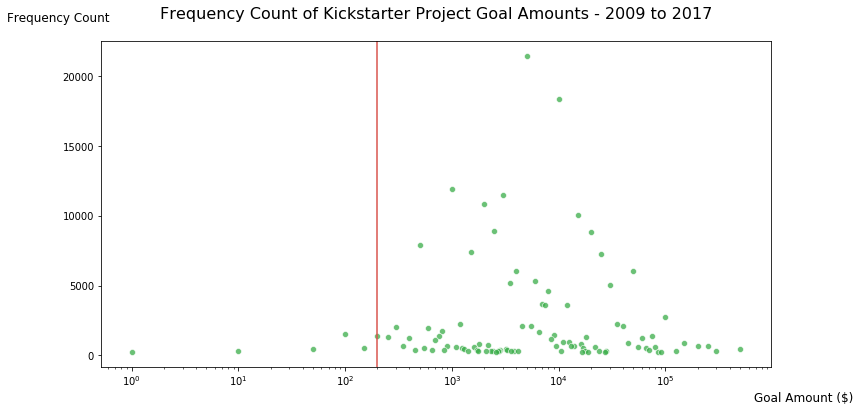

In [21]:
amounts = ks2018['goal'].value_counts().index
frequency = ks2018['goal'].value_counts()

plt.figure(figsize = (12,6));
sns.scatterplot(amounts[:100], frequency[:100,], alpha = 0.75, color = sns.xkcd_rgb["medium green"]);

#restricting the amount to $200
plt.axvline(x=200, color = sns.xkcd_rgb["pale red"]);

plt.xscale('log');
plt.title('Frequency Count of Kickstarter Project Goal Amounts - 2009 to 2017', fontsize = '16', y= 1.05);
plt.xlabel(xlabel = 'Goal Amount ($)', x = 1.05, fontsize = '12');
plt.ylabel(ylabel = 'Frequency Count', rotation = 0, y = 1.05, fontsize = '12');

A lot of successful Kickstarter campaigns have at least 20 project backers. <br>
Curiously, some have 0 backers, so the data needs to be further cleaned.

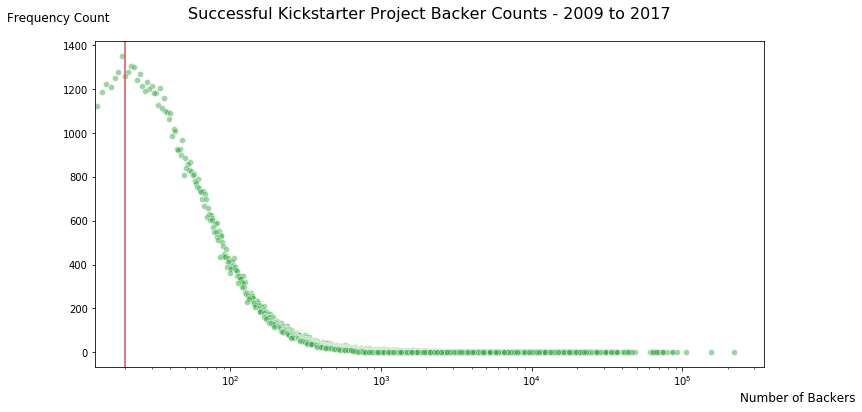

In [22]:
successful = ks2018[ks2018['successful'] == 1]
amounts = successful['backers'].value_counts().index
frequency = successful['backers'].value_counts()

plt.figure(figsize = (12,6));
sns.scatterplot(amounts, frequency, alpha = 0.5, color = sns.xkcd_rgb["medium green"]);

#20 backers or so
plt.axvline(x=20, color = sns.xkcd_rgb["pale red"]);

plt.xscale('log');
plt.title('Successful Kickstarter Project Backer Counts - 2009 to 2017', fontsize = '16', y= 1.05);
plt.xlabel(xlabel = 'Number of Backers', x = 1.05, fontsize = '12');
plt.ylabel(ylabel = 'Frequency Count', rotation = 0, y = 1.05, fontsize = '12');

As the plots revealed, the goal amounts for Kickstarter campaigns can be very small. <br>
This helps explain why the number of backers is also low for successful campaigns. <br>
The data was restricted to an arbitrary goal amount of $200 instead. <br>
The number of backers should also be greater than 0.

In [23]:
goal_mask = ks2018['goal'] < 200
goal_indices = ks2018[goal_mask].index

ks2018 = ks2018[~ks2018.index.isin(goal_indices)]

In [24]:
backer_mask = ks2018['backers'] > 0
backer_indices = ks2018[backer_mask].index

ks2018 = ks2018[ks2018.index.isin(backer_indices)]

Notice how statistics like the average Kickstarter campaign donation amount or the average number of backers was not used. <br>
The statistics vary by year so it would be best to study the behavior via a bar chart first.  

In [25]:
def year_statistics(mask):
    """
        Helper function to gather yearly statistics from the ks2018 dataframe
        
        :param mask: additional mask for masking the ks2018 dataframe
        :returns year_dict: a dictionary that contains average pledged amount, 
                            median pledged amount, average number of backers, 
                            median number of backers, average donation, median donation
    """

    years = sorted(ks2018['year'].value_counts().index)

    year_dict = {}

    for year in years:
        
        try:
            if mask.any():
                year_mask = (ks2018['year'] == year) & mask
        except:
            year_mask = (ks2018['year'] == year)

        avg_num_backers = round(ks2018.loc[year_mask, 'backers'].mean(), 2)
        median_num_backers =round(ks2018.loc[year_mask, 'backers'].median(), 2)

        avg_campaign_donations = ks2018.loc[year_mask, 'pledged']/ks2018.loc[year_mask, 'backers']

        avg_donation = round(avg_campaign_donations.mean(), 2)
        median_donation = round(avg_campaign_donations.median(), 2)

        year_dict[year] = {'Average Number of Backers': avg_num_backers,
                           'Median Number of Backers': median_num_backers,
                           'Average Donation': avg_donation,
                           'Median Donation': median_donation}
    
    pp.pprint(year_dict)
    
    return year_dict

In [26]:
year_dict = year_statistics(mask = None)

{'2009': {'Average Donation': 65.31,
          'Average Number of Backers': 42.53,
          'Median Donation': 50.0,
          'Median Number of Backers': 23.0},
 '2010': {'Average Donation': 72.82,
          'Average Number of Backers': 48.1,
          'Median Donation': 54.1,
          'Median Number of Backers': 24.0},
 '2011': {'Average Donation': 72.73,
          'Average Number of Backers': 63.61,
          'Median Donation': 54.35,
          'Median Number of Backers': 26.0},
 '2012': {'Average Donation': 71.93,
          'Average Number of Backers': 121.84,
          'Median Donation': 51.28,
          'Median Number of Backers': 28.0},
 '2013': {'Average Donation': 76.77,
          'Average Number of Backers': 159.42,
          'Median Donation': 52.08,
          'Median Number of Backers': 33.0},
 '2014': {'Average Donation': 73.47,
          'Average Number of Backers': 118.58,
          'Median Donation': 46.83,
          'Median Number of Backers': 18.0},
 '2015': {'Avera

In [27]:
def bar_plotter(key, year_dict, save_fig = False):
    """
        Function that produces a bar plot
        
        :param key: key value to use for year_dict
        :param year_dict: dictionary of values
        :save_fig: boolean for indicating whether to save the plot
    """
    
    plt.figure(figsize = (12,6));
    
    entries = []
    years = []
    
    for year, values in year_dict.items():
        years.append(year)
        entries.append(values[key])
    
    sns.barplot(years, entries, color = sns.xkcd_rgb["medium green"], alpha = 0.7);

    plt.title(key + ' - 2009 to 2017', fontsize = '16', y= 1.05);
    plt.ylabel(ylabel = key, rotation = 0, y = 1.05, fontsize = '12');
    
        
    if savefig:
        plt.savefig("./img/" + key + ' - 2009 to 2017' + ".png")

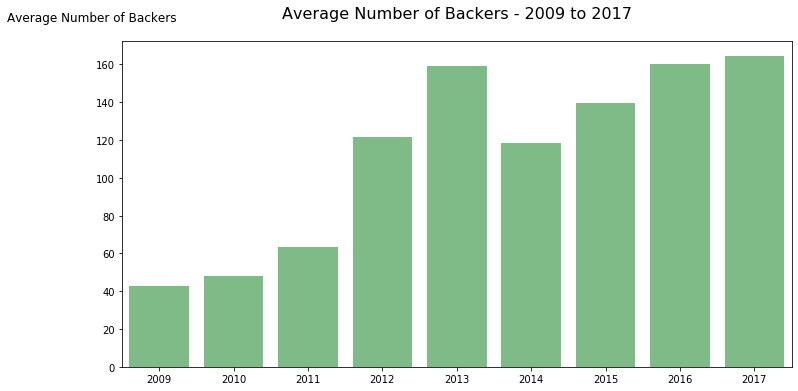

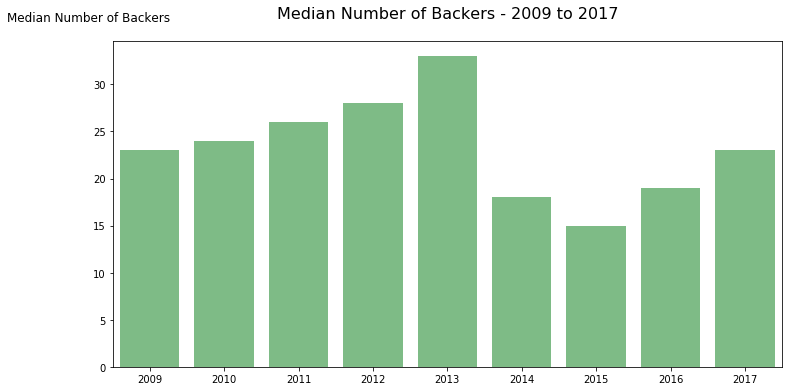

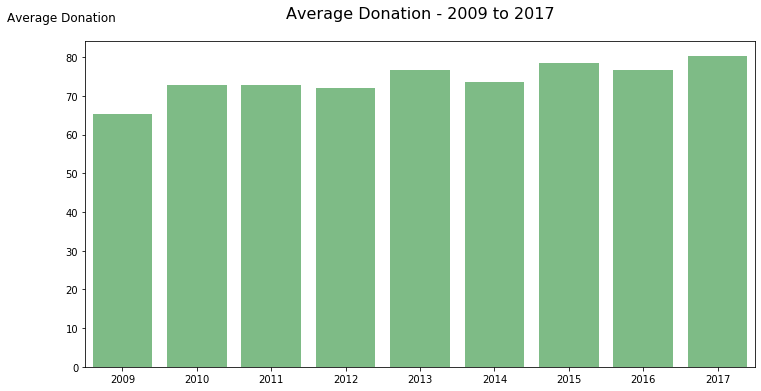

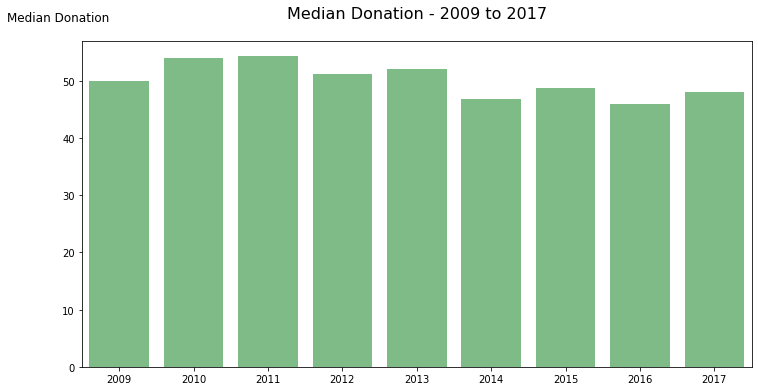

In [28]:
keys = year_dict['2009'].keys()

for key in keys:
    bar_plotter(key, year_dict)

The statistics vary widely across the years, with the median number of backers being the most stable. <br>
The median number of backers also matches the red line we had before. <br>
If we look at the data across all the years, we have:

In [29]:
avg_num_backers = round(ks2018['backers'].mean(), 2)
median_num_backers =round(ks2018['backers'].median(), 2)

avg_campaign_donations = ks2018['pledged']/ks2018['backers']

avg_donation = round(avg_campaign_donations.mean(), 2)
median_donation = round(avg_campaign_donations.median(), 2)
                                     
print('Average Number of Backers: {}'.format(avg_num_backers))
print('Median Number of Backers: {}'.format(median_num_backers))
print('Average Donation: {}'.format(avg_donation))
print('Median Donation: {}'.format(median_donation))

Average Number of Backers: 134.04
Median Number of Backers: 22.0
Average Donation: 75.93
Median Donation: 49.97


If we examine only successful campaigns across the years instead, we have a different picture. <br>
The median and average donation are higher across the years, and in total as well.

In [30]:
successful = (ks2018['successful'] == 1)

year_dict = year_statistics(mask = successful)

{'2009': {'Average Donation': 75.17,
          'Average Number of Backers': 68.29,
          'Median Donation': 59.33,
          'Median Number of Backers': 46.0},
 '2010': {'Average Donation': 83.74,
          'Average Number of Backers': 78.31,
          'Median Donation': 64.97,
          'Median Number of Backers': 48.0},
 '2011': {'Average Donation': 82.55,
          'Average Number of Backers': 102.43,
          'Median Donation': 63.64,
          'Median Number of Backers': 51.0},
 '2012': {'Average Donation': 82.0,
          'Average Number of Backers': 218.84,
          'Median Donation': 62.02,
          'Median Number of Backers': 65.0},
 '2013': {'Average Donation': 88.32,
          'Average Number of Backers': 288.95,
          'Median Donation': 63.55,
          'Median Number of Backers': 79.0},
 '2014': {'Average Donation': 95.93,
          'Average Number of Backers': 263.05,
          'Median Donation': 66.65,
          'Median Number of Backers': 80.0},
 '2015': {'Av

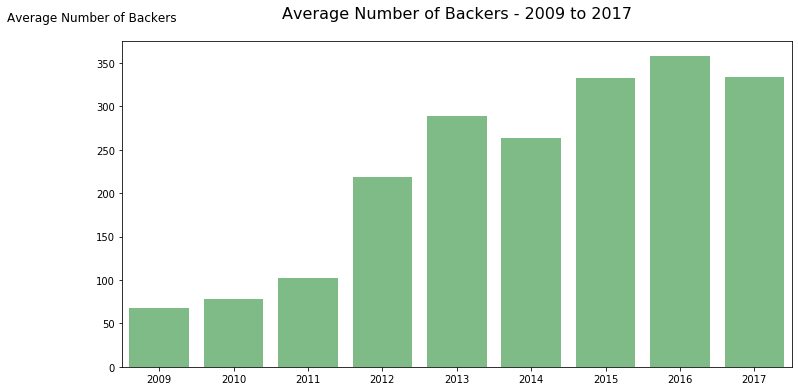

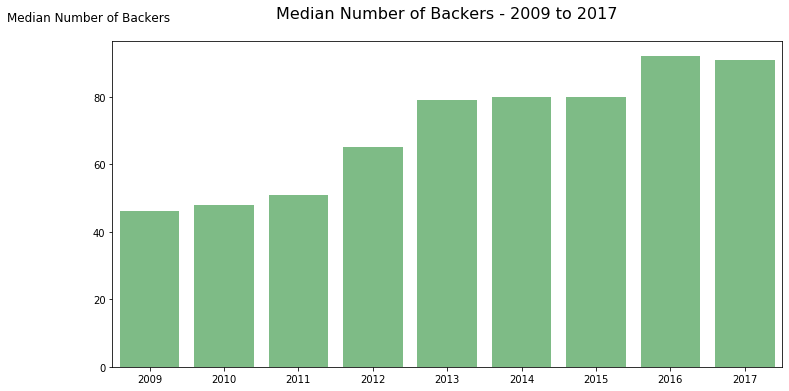

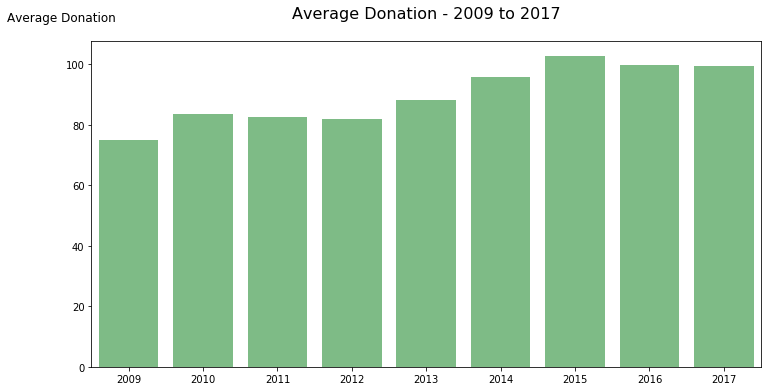

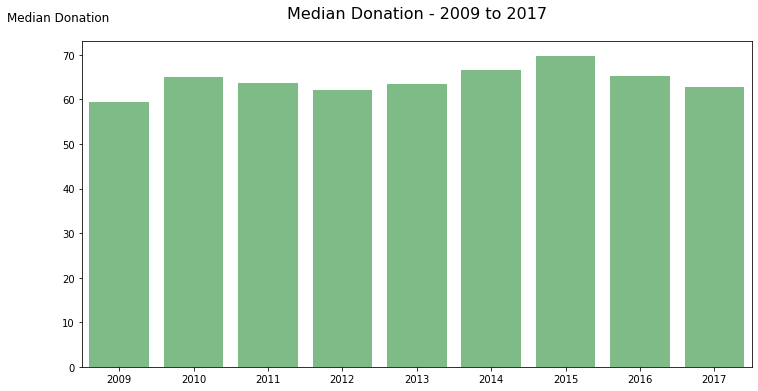

In [31]:
keys = year_dict['2009'].keys()

for key in keys:
    bar_plotter(key, year_dict)

In [32]:
avg_num_backers = round(ks2018.loc[successful, 'backers'].mean(), 2)
median_num_backers =round(ks2018.loc[successful, 'backers'].median(), 2)

avg_campaign_donations = ks2018.loc[successful, 'pledged']/ks2018.loc[successful, 'backers']

avg_donation = round(avg_campaign_donations.mean(), 2)
median_donation = round(avg_campaign_donations.median(), 2)
                                     
print('Average Number of Backers: {}'.format(avg_num_backers))
print('Median Number of Backers: {}'.format(median_num_backers))
print('Average Donation: {}'.format(avg_donation))
print('Median Donation: {}'.format(median_donation))

Average Number of Backers: 271.91
Median Number of Backers: 74.0
Average Donation: 93.22
Median Donation: 64.82


In the next section, we shall use the lowest median number of backers for successful campaigns across all years - roughly 45.


Return to [Table of Contents](#table)

## 5. Data Leakage <a name="leak"></a>

Aside from the target variable, 'successful', there are some other columns that need to be addressed before modeling. <br>
The columns 'pledged' and 'backers' are both obvious indicators of success. <br>
The greater the number of backers, the more money pledged. <br>
The more money pledged, the more likely a Kickstarter campaign will succeed. <br>
The information provided by 'pledged' and 'backers' is knowledge known after campaigns end. <br>
Removing or modifiying these two columns will help with data leakage. <br>
In this case, I chose to remove the 'pledged' column after plotting. <br>
We also no longer need the 'year' column.

In [33]:
ks2018 = ks2018.drop(['pledged', 'year'], axis = 1)
ks2018.head()

,title_length,successful,backers,US,goal,project_duration,min_30_days,art,comics,crafts,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
1,8,0,15,1,30000.0,59.80,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,3,1,45000.0,44.99,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,1,1,5000.0,29.86,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,224,1,50000.0,34.43,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,9,1,16,1,1000.0,19.23,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


According to Kickstarter, the average Kickstarter campaign donation is $25. <br>
Since we do not have user data, that is not a statistic we can verify. <br>
It does not agree with the median or average donated amounts we have. <br>
Instead, we check to see if the number of backers is at minimum 45. <br>
For all years, 45 is about the lowest median number of backers for all successful campaigns. 

In [34]:
ks2018['backers'] = ks2018['backers'].apply(lambda num_backers: 1 if num_backers >= 45 else 0)
ks2018 = ks2018.rename(columns = {'backers':'min_45_backers'})

ks2018.head()

,title_length,successful,min_45_backers,US,goal,project_duration,min_30_days,art,comics,crafts,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
1,8,0,0,1,30000.0,59.80,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,0,1,45000.0,44.99,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,0,1,5000.0,29.86,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,1,1,50000.0,34.43,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,9,1,0,1,1000.0,19.23,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Return to [Table of Contents](#table)

## 6. Saving Data <a name="save"></a>

We pickle the data for later.

In [36]:
file_dir = os.path.abspath('.')
data_folder = 'data'
path = os.path.join(file_dir, data_folder, 'ks2018.pkl')

ks2018.to_pickle(path)

In [37]:
pd.read_pickle(path).head()

,title_length,successful,min_45_backers,US,goal,project_duration,min_30_days,art,comics,crafts,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
1,8,0,0,1,30000.0,59.80,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,0,1,45000.0,44.99,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,0,1,5000.0,29.86,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,1,1,50000.0,34.43,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,9,1,0,1,1000.0,19.23,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Return to [Table of Contents](#table)